In [1]:
from phase_portrait import *
import yfinance as yf
%matplotlib inline

In [2]:
downloaded_data_nas = yf.download("^IXIC", "1990-01-02","2022-02-19")
downloaded_data_nas['date'] = downloaded_data_nas.index
downloaded_data_nas['value'] =  downloaded_data_nas[['Adj Close']]
downloaded_data_nas = downloaded_data_nas.reset_index(drop=True)
downloaded_data_nas = downloaded_data_nas[['date', 'value']]

[*********************100%***********************]  1 of 1 completed


In [3]:
df = downloaded_data_nas.copy()

Для исследования методов построения фазовых портретов рассмотрим промежуток.

In [4]:
start_date_dfc = '26.12.1997'
end_date_dfc = '29.12.2006'

dates_mask = get_dates_mask(df['date'], start_date_dfc, end_date_dfc)
df = df[dates_mask].reset_index(drop=True)

Так как мы анализируем высокочастотные данные, то требуется произвести прореживание. Поставим период прореживание = 30 элементов (дней, но индекс обновляется только по рабочим дням, поэтому нельзя утверждать, что прореживание будет 30 дней). Так же сохраним прошлые индексы, чтобы понять, какой параметр наилучшим образом подходит для построения сплайнов.

In [4]:
slice_period = 30
df = slice_data(df, slice_period=slice_period, reset_index=False)
df = df.reset_index()

Сначала рассмотрим построение портретов по индексу.

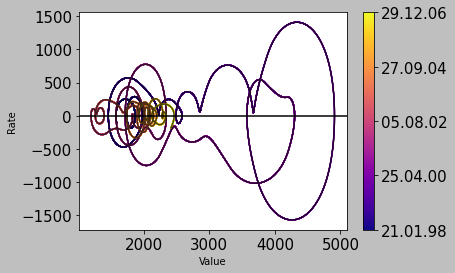

In [16]:
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
fig, ax = plot_phase_portrait(x, tt, deriv, df['date'])

plt.show()

KeyboardInterrupt: 

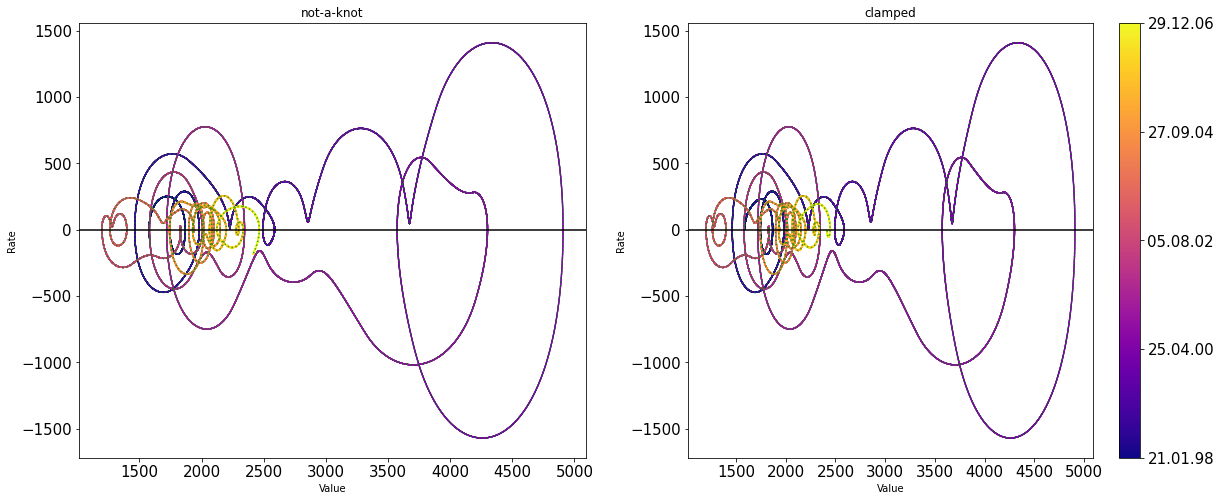

In [34]:
df = downloaded_data_nas.copy()
fig, ax = plt.subplots(ncols= 2)
bc_type='not-a-knot'
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'], params={'get_phase_portrait.bc_type': bc_type})
plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[0], graph_name=bc_type, plot_bar=False)
bc_type='clamped'
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'], params={'get_phase_portrait.bc_type': bc_type})
plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[1], graph_name=bc_type)
fig.set_figheight(8)
fig.set_figwidth(20)
# plt.savefig(f"Nasdaq_comparison_spline_methods_monthly_crop_.png", dpi=200)
plt.show()

In [ ]:
df = downloaded_data_nas.copy()
slice_period = 30
df = slice_data(df, slice_period=slice_period, reset_index=False)
df = df.reset_index()

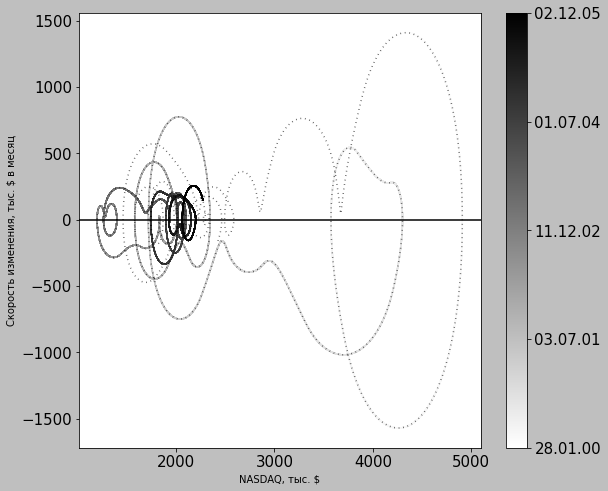

In [14]:
plt.style.use('grayscale')
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
fig, ax = plot_phase_portrait(x, tt, deriv, df['date'], cmap=mpl.cm.get_cmap('gist_yarg'), background_graph_params={'color': 'black', 'linestyle':(0, (0.5, 2.5))}, start_date='01.01.2000', end_date='01.01.2006', xlabel='NASDAQ, тыс. $', ylabel='Скорость изменения, тыс. $ в месяц')
# start_date_dfc = '26.12.1997' end_date_dfc = '29.12.2006'
fig.set_figheight(8)
fig.set_figwidth(9)
plt.savefig(f"test_1.png", dpi=200)
plt.show()

UPDATED


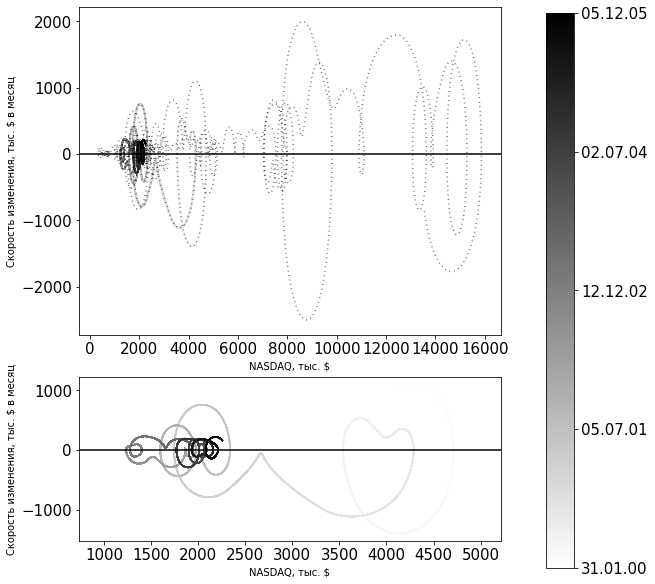

In [7]:
from phase_portrait import plot_phase_portrait
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])

fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(6, 4, figure=fig)
ax1 = fig.add_subplot(gs[:4, :3])
ax2 = fig.add_subplot(gs[4:6, :3])
cmap = mpl.cm.get_cmap('gist_yarg')
start_date = '01.01.2000'
end_date = '01.01.2006'
fig1, ax1 = plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'color': 'black', 'linestyle':(0, (0.5, 2.5))}, start_date=start_date, end_date=end_date, xlabel='NASDAQ, тыс. $', ylabel='Скорость изменения, тыс. $ в месяц', plot_bar=False, fig=fig, ax=ax1)

fig2, ax2 = plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'disable': True}, xlabel='NASDAQ, тыс. $', ylabel='Скорость изменения, тыс. $ в месяц', plot_bar=False, fig=fig, ax=ax2, crop=True, start_date=start_date, end_date=end_date)
###### cbar
# ax3 = fig.add_subplot(gs[:, 3])
ax3 = fig.add_subplot(1,1,1)
ax3.axis('off')
dates_colored_mask = get_dates_mask(df['date'], start_date, end_date)
colored_mask = get_mask_tt(x, tt, dates_mask=dates_colored_mask)
tt_colored = tt[colored_mask]
norm = mpl.colors.Normalize(vmin=tt_colored.min(), vmax=tt_colored.max())
cbar_ticks_num=5

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                            orientation='vertical', ticks=get_ticks(tt_colored, cbar_ticks_num), ax=ax3)
cbar.ax.set_yticklabels(
    map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'][dates_colored_mask], cbar_ticks_num)))
#########
fig.set_figheight(8)
fig.set_figwidth(9)

plt.savefig(f"test_subplots.png", dpi=200)

plt.show()